In [3]:
import numpy as np
import pandas as pd

import sys
import os
import random
from pathlib import Path

In [4]:
import imageio
import skimage
import skimage.io
import skimage.transform

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [7]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import tensorflow

In [16]:
# Set random seed to make results reproducable
np.random.seed(42)
tensorflow.set_random_seed(42)

# Global variables
img_folder = './bee_imgs/bee_imgs/'
img_width = 100
img_height = 100
img_channels = 3

In [23]:
bees=pd.read_csv('bee_data.csv', 
                index_col=False,  
                parse_dates={'datetime':[1,2]},
                dtype={'subspecies':'category', 'health':'category','caste':'category'})

In [25]:
# Will use this function later to load images of preprocessed bees
# Don't load images just from the start to save memory for preprocessing steps
def read_img(file):
    """
    Read and resize img, adjust channels. 
    Caution: This function is not independent, it uses global vars: img_folder, img_channels
    @param file: file name without full path
    """
    img = skimage.io.imread(img_folder + file)
    img = skimage.transform.resize(img, (img_width, img_height), mode='reflect')
    return img[:,:,:img_channels]

# Cannot impute nans, drop them
bees.dropna(inplace=True)

# Some image files don't exist. Leave only bees with available images.
img_exists = bees['file'].apply(lambda f: os.path.exists(img_folder + f))
bees = bees[img_exists]

bees.head()

,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


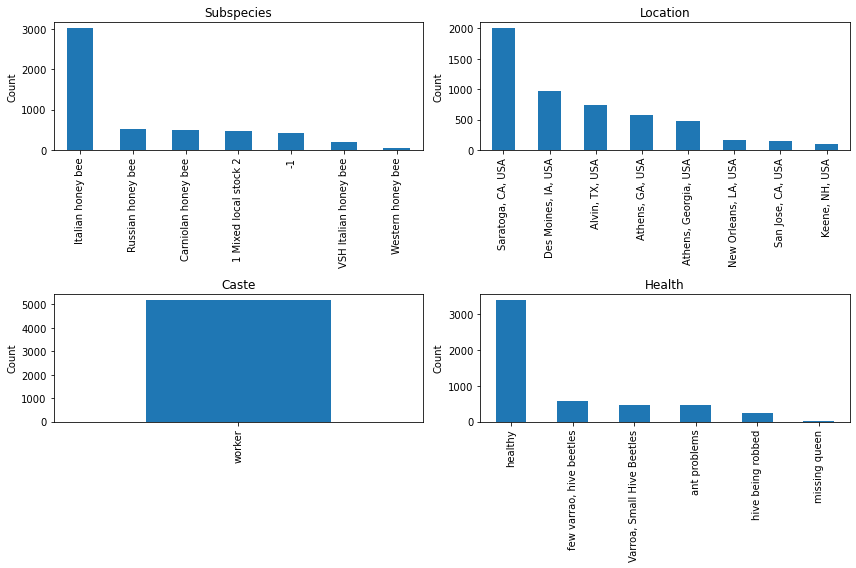

In [26]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

bees.subspecies.value_counts().plot(kind='bar',ax=ax[0, 0])
ax[0,0].set_ylabel('Count')
ax[0,0].set_title('Subspecies')

bees.location.value_counts().plot(kind='bar', ax=ax[0, 1])
ax[0,1].set_title('Location')
ax[0,1].set_ylabel('Count')

bees.caste.value_counts().plot(kind='bar', ax=ax[1, 0])
ax[1,0].set_title('Caste')
ax[1,0].set_ylabel('Count')

bees.health.value_counts().plot(kind='bar', ax=ax[1,1])
ax[1,1].set_title('Health')
ax[1,1].set_ylabel('Count')

f.subplots_adjust(hspace=0.7)
f.tight_layout()
plt.show()

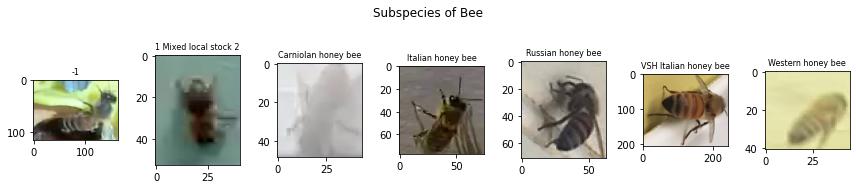

In [27]:
# Select first X subspecies titles 
subspecies = bees['subspecies'].cat.categories
f, ax = plt.subplots(nrows=1,ncols=subspecies.size, figsize=(12,3))
i=0
# Draw the first found bee of given subpecies
for s in subspecies:
    if s == 'healthy': continue
    file=img_folder + bees[bees['subspecies']==s].iloc[0]['file']
    im=imageio.imread(file)
    ax[i].imshow(im, resample=True)
    ax[i].set_title(s, fontsize=8)
    i+=1
    
plt.suptitle("Subspecies of Bee")
plt.tight_layout()
plt.show()

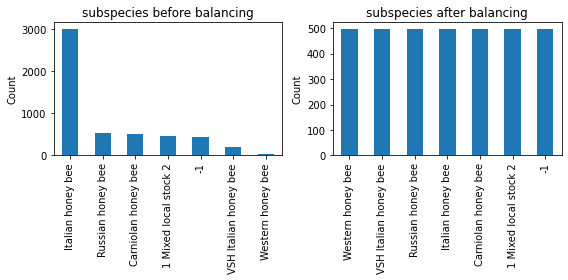

In [28]:
# Let's put this logic in function here to reuse.
def split_balance(bees, field_name):
    """ 
    Split to train, test and validation. 
    Then balance train by given field name.
    Draw plots before and after balancing
    
    @param bees: Total Bees dataset to balance and split
    @param field_name: Field to balance by
    @return:  balanced train bees, validation bees, test bees
    """
    # Split to train and test before balancing
    train_bees, test_bees = train_test_split(bees, random_state=24)

    # Split train to train and validation datasets
    # Validation for use during learning
    train_bees, val_bees = train_test_split(train_bees, test_size=0.1, random_state=24)

    #Balance by subspecies to train_bees_bal_ss dataset
    # Number of samples in each category
    ncat_bal = int(len(train_bees)/train_bees[field_name].cat.categories.size)
    train_bees_bal = train_bees.groupby(field_name, as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True)).reset_index(drop=True)
    return(train_bees_bal, val_bees, test_bees)
    
def plot_balanced(train_bees, train_bees_bal, field_name):
    """
    Draw distribution of field by categories before and after balancing
    @param train_bees: before balancing
    @param train_bees_bal: after balancing
    @param field_name: balancing field
    """
    # Plot before and after balancing
    f, axs = plt.subplots(1,2, figsize=(8,4))

    # Before
    ax = train_bees[field_name].value_counts().plot(kind='bar', ax=axs[0])
    ax.set_title('%s before balancing' % field_name)
    ax.set_ylabel('Count')

    # After
    ax = train_bees_bal[field_name].value_counts().plot(kind='bar', ax=axs[1])
    ax.set_title('%s after balancing' % field_name)
    ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Split/balance and plot the result
train_bees_bal, val_bees, test_bees = split_balance(bees, 'subspecies')
plot_balanced(bees, train_bees_bal, 'subspecies')

# Will use balanced dataset as main
train_bees = train_bees_bal

#### Bee Species Classification

In [29]:
# The same way of loading images and one hot encoding will be used in 2 places: subspecies and health CNN.
# Let's put this logic in function here to reuse.
def prepare2train(train_bees, val_bees, test_bees, field_name):
    """
    Load images for features, drop other columns
    One hot encode for label, drop other columns
    @return: image generator, train images, validation images, test images, train labels, validation labels, test labels
    """
    # Bees already splitted to train, validation and test
    # Load and transform images to have equal width/height/channels. 
    # read_img function is defined in the beginning to use in both health and subspecies. 
    # Use np.stack to get NumPy array for CNN input

    # Train data
    train_X = np.stack(train_bees['file'].apply(read_img))
    #train_y = to_categorical(train_bees[field_name].values)
    train_y  = pd.get_dummies(train_bees[field_name], drop_first=False)

    # Validation during training data to calc val_loss metric
    val_X = np.stack(val_bees['file'].apply(read_img))
    #val_y = to_categorical(val_bees[field_name].values)
    val_y = pd.get_dummies(val_bees[field_name], drop_first=False)

    # Test data
    test_X = np.stack(test_bees['file'].apply(read_img))
    #test_y = to_categorical(test_bees[field_name].values)
    test_y = pd.get_dummies(test_bees[field_name], drop_first=False)

    # Data augmentation - a little bit rotate, zoom and shift input images.
    generator = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)
    generator.fit(train_X)
    return (generator, train_X, val_X, test_X, train_y, val_y, test_y)

#train_bees['subspecies'].cat.values[:-100]
# Call image preparation and one hot encoding
generator, train_X, val_X, test_X, train_y, val_y, test_y = prepare2train(train_bees, val_bees, test_bees, 'subspecies')

In [43]:
# We'll stop training if no improvement after some epochs
earlystop = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Save the best model during the traning
checkpoint = ModelCheckpoint('best_model1.h5'
                                ,monitor='val_accuracy'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True,
                               mode='max')

In [44]:
# Build CNN model
model1=Sequential()
model1.add(Conv2D(6, kernel_size=3, input_shape=(img_width, img_height,3), activation='relu', padding='same'))
model1.add(MaxPool2D(2))
model1.add(Conv2D(12, kernel_size=3, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(train_y.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
training1 = model1.fit_generator(generator.flow(train_X,train_y, batch_size=60)
                        ,epochs=20
                        ,validation_data=[val_X, val_y]
                        ,steps_per_epoch=50
                        ,callbacks=[earlystop,checkpoint])
# Get the best saved weights
model1.load_weights('best_model1.h5')

Epoch 1/20
50/50 [==============================] - 10s 194ms/step - loss: 1.5703 - accuracy: 0.4243 - val_loss: 1.1469 - val_accuracy: 0.5490

Epoch 00001: val_accuracy improved from -inf to 0.54897, saving model to best_model1.h5
Epoch 2/20
50/50 [==============================] - 10s 194ms/step - loss: 0.7960 - accuracy: 0.7281 - val_loss: 1.0878 - val_accuracy: 0.5979

Epoch 00002: val_accuracy improved from 0.54897 to 0.59794, saving model to best_model1.h5
Epoch 3/20
50/50 [==============================] - 10s 191ms/step - loss: 0.6219 - accuracy: 0.7957 - val_loss: 0.9829 - val_accuracy: 0.6495

Epoch 00003: val_accuracy improved from 0.59794 to 0.64948, saving model to best_model1.h5
Epoch 4/20
50/50 [==============================] - 10s 190ms/step - loss: 0.5293 - accuracy: 0.8310 - val_loss: 0.7375 - val_accuracy: 0.7706

Epoch 00004: val_accuracy improved from 0.64948 to 0.77062, saving model to best_model1.h5
Epoch 5/20
50/50 [==============================] - 10s 200ms/s

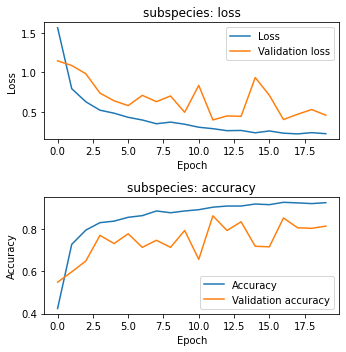

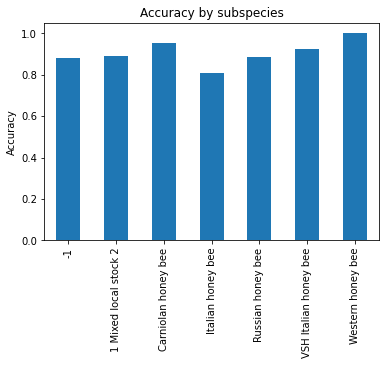

Classification report
                       precision    recall  f1-score   support

                   -1       0.86      0.88      0.87       108
1 Mixed local stock 2       0.49      0.89      0.63       102
  Carniolan honey bee       1.00      0.96      0.98       147
    Italian honey bee       0.97      0.83      0.89       754
    Russian honey bee       0.99      0.91      0.95       124
VSH Italian honey bee       0.56      0.94      0.70        54
    Western honey bee       1.00      1.00      1.00         4

             accuracy                           0.86      1293
            macro avg       0.84      0.92      0.86      1293
         weighted avg       0.91      0.86      0.88      1293

Loss function: 0.382415813710094, accuracy: 0.8646558523178101


In [47]:
# This is a function to use in Bee subspecies and health evaluation
def eval_model(training, model, test_X, test_y, field_name):
    """
    Model evaluation: plots, classification report
    @param training: model training history
    @param model: trained model
    @param test_X: features 
    @param test_y: labels
    @param field_name: label name to display on plots
    """
    ## Trained model analysis and evaluation
    f, ax = plt.subplots(2,1, figsize=(5,5))
    ax[0].plot(training.history['loss'], label="Loss")
    ax[0].plot(training.history['val_loss'], label="Validation loss")
    ax[0].set_title('%s: loss' % field_name)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # Accuracy
    ax[1].plot(training1.history['accuracy'], label="Accuracy")
    ax[1].plot(training1.history['val_accuracy'], label="Validation accuracy")
    ax[1].set_title('%s: accuracy' % field_name)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    # Accuracy by subspecies
    test_pred = model.predict(test_X)
    
    acc_by_subspecies = np.logical_and((test_pred > 0.5), test_y).sum()/test_y.sum()
    acc_by_subspecies.plot(kind='bar', title='Accuracy by %s' % field_name)
    plt.ylabel('Accuracy')
    plt.show()

    # Print metrics
    print("Classification report")
    test_pred = np.argmax(test_pred, axis=1)
    test_truth = np.argmax(test_y.values, axis=1)
    print(metrics.classification_report(test_truth, test_pred, target_names=test_y.columns))

    # Loss function and accuracy
    test_res = model.evaluate(test_X, test_y.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

# Call evaluation function
eval_model(training1, model1, test_X, test_y, 'subspecies')

### Bee health classification

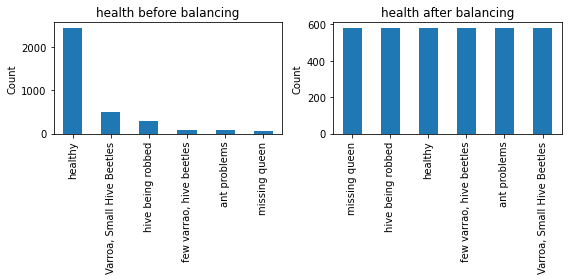

In [48]:
# Split/balance and plot the result
train_bees_bal, val_bees, test_bees = split_balance(bees, 'health')
plot_balanced(train_bees, train_bees_bal, 'health')

# Will use balanced dataset as main
train_bees_bal = train_bees

In [49]:
# Call image preparation and one hot encoding from Bee subspecies section
generator, train_X, val_X, test_X, train_y, val_y, test_y = prepare2train(train_bees, val_bees, test_bees, 'health')

In [51]:
# We'll stop training if no improvement after some epochs
earlystopper2 = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Save the best model during the traning
checkpointer2 = ModelCheckpoint('best_model2.h5'
                                ,monitor='val_accuracy'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True,
                               mode='max')
# Build CNN model
model2=Sequential()
model2.add(Conv2D(5, kernel_size=3, input_shape=(img_width, img_height,3), activation='relu', padding='same'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(10, kernel_size=3, activation='relu', padding='same'))
model2.add(Flatten())
model2.add(Dense(train_y.columns.size, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
training2 = model2.fit_generator(generator.flow(train_X,train_y, batch_size=60)
                        ,epochs=20
                        ,validation_data=[val_X, val_y]
                        ,steps_per_epoch=50
                        ,callbacks=[earlystopper2, checkpointer2])
# Get the best saved weights
model2.load_weights('best_model2.h5')

Epoch 1/20
50/50 [==============================] - 9s 189ms/step - loss: 0.8651 - accuracy: 0.7137 - val_loss: 1.2827 - val_accuracy: 0.5902

Epoch 00001: val_accuracy improved from -inf to 0.59021, saving model to best_model2.h5
Epoch 2/20
50/50 [==============================] - 9s 181ms/step - loss: 0.7078 - accuracy: 0.7911 - val_loss: 1.1461 - val_accuracy: 0.6624

Epoch 00002: val_accuracy improved from 0.59021 to 0.66237, saving model to best_model2.h5
Epoch 3/20
50/50 [==============================] - 11s 222ms/step - loss: 0.5459 - accuracy: 0.8374 - val_loss: 0.9859 - val_accuracy: 0.6753

Epoch 00003: val_accuracy improved from 0.66237 to 0.67526, saving model to best_model2.h5
Epoch 4/20
50/50 [==============================] - 10s 209ms/step - loss: 0.5275 - accuracy: 0.8427 - val_loss: 1.0177 - val_accuracy: 0.6804

Epoch 00004: val_accuracy improved from 0.67526 to 0.68041, saving model to best_model2.h5
Epoch 5/20
50/50 [==============================] - 10s 208ms/ste

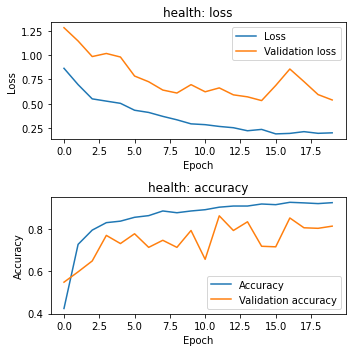

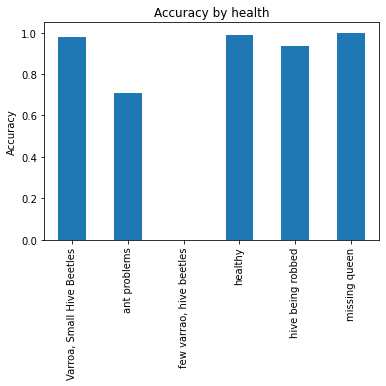

Classification report
                            precision    recall  f1-score   support

Varroa, Small Hive Beetles       0.46      0.99      0.63       102
              ant problems       0.99      0.72      0.83       117
  few varrao, hive beetles       1.00      0.01      0.01       139
                   healthy       0.95      0.99      0.97       866
         hive being robbed       0.70      0.93      0.80        61
             missing queen       1.00      1.00      1.00         8

                  accuracy                           0.86      1293
                 macro avg       0.85      0.77      0.71      1293
              weighted avg       0.91      0.86      0.82      1293

Loss function: 0.5854620369754829, accuracy: 0.8561484813690186


In [52]:
# Call evaluation with charts, defined in Bee subspecies section
eval_model(training2, model2, test_X, test_y, 'health')